In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch as th

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['text.latex.preamble'] = r"\usepackage{lmodern} \usepackage{amsmath}"
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
        #   'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

In [8]:
class Bandit():
  ''' Class which takes the no of action, mean and variance as input '''
  def __init__(self,n_action=10,mean=0,variance=1, name=None):
    self.n_action = n_action
    self.mean = mean 
    self.center_variance = variance
    self.action_variance = variance
    if name == 'near zero':
      self.q_star = np.arange(-5,-2, (3/self.n_action)) # creating a linear space of q_star
    elif name == 'near one':
      self.q_star = np.arange(1,5, (4/self.n_action))
    elif name == 'evenly spaced':
      self.q_star = np.arange(-3,3, (6/self.n_action))
    else:
      self.q_star = np.random.normal(self.mean,self.center_variance,self.n_action)
    self.s_q_star = self.compute_sigmoid_q_star()
  
  def compute_sigmoid_q_star(self):
    num_samples = int(1e7)
    s_qstar = np.zeros(self.n_action)
    for i in range(len(self.q_star)):
      real_rewards = np.random.normal(self.q_star[i], self.action_variance , num_samples)
      sigmoid_rewards = 1/(1+np.exp(-real_rewards))
      s_qstar[i] = np.mean(sigmoid_rewards)
    return s_qstar

  def return_no_actions(self):
    return self.n_action
  
  def optimal_action(self):
    return np.argmax(self.q_star)
  
  def pull_numpy(self,action):
    # print(self.q_star[action])
    s = np.random.normal(self.q_star[action], 1 , 1)
    # print(s)
    sigmoid_s = 1/(1+np.exp(-s))
    assert sigmoid_s <= 1 and sigmoid_s >= 0
    return sigmoid_s[0]

  def pull(self,action):
    action_th = th.tensor(self.q_star[action])
    variance_th = th.tensor(self.action_variance)
    std = variance_th.repeat(action_th.size())**0.5
    s = th.normal(action_th, std)
    sigmoid_s = 1/(1+th.exp(-s))
    assert sigmoid_s.all() <= 1 and sigmoid_s.all() >= 0
    return sigmoid_s
  
  def return_exp_optimal_reawrd(self):
    return np.max(self.q_star)

In [9]:
def voter_rule(runs,population_size,epochs,bandit):
    mean_rewards = np.zeros((epochs,runs))
    optimal_action = np.zeros((epochs,runs))

    for j in range(epochs):
        population = np.repeat(np.arange(bandit.n_action), population_size//bandit.n_action) # initial population
        pop_types = np.arange(0, population_size)
        for i in range(runs):
            policy_vector = np.zeros(bandit.n_action)
            types, counts = np.unique(population , return_counts=True)
            policy_vector[types] = counts/population_size
            optimal_action[j,i] = policy_vector[bandit.optimal_action()]
            population_th = th.tensor(population)
            rewards = bandit.pull(population_th)
            shuffled_pop_types = pop_types.copy()
            np.random.shuffle(shuffled_pop_types)
            imitating_partner = population[shuffled_pop_types]
            imitating_reward = rewards.numpy()[shuffled_pop_types]
            probabilities = np.random.rand(population_size)
            population = np.where(probabilities < imitating_reward, imitating_partner, population)
            mean_rewards[j,i] = np.mean(rewards.numpy())

    
    return mean_rewards, optimal_action


In [10]:
def taylor_replicator_dynamics(alpha,bandit,runs):
    dt = alpha
    time = np.arange(0,alpha*runs,dt)
    mean_reward_trd = np.zeros(len(time))
    s_qstar = bandit.s_q_star
    x = np.ones(bandit.return_no_actions())*1/bandit.return_no_actions()

    for i in range(len(time)):
        mean_reward_trd[i] = np.dot(x,s_qstar)
        dx = np.zeros(len(x))
        dx = x*(s_qstar - np.dot(s_qstar,x))
        x = x + dx*dt
    return mean_reward_trd

In [11]:
def maynard_replicator_dynamics(alpha,bandit,runs):
    dt = alpha
    time = np.arange(0,alpha*runs,dt)
    mean_reward_mrd = np.zeros(len(time))
    s_qstar = bandit.s_q_star
    x = np.ones(bandit.return_no_actions())*1/bandit.return_no_actions()


    for i in range(len(time)):
        mean_reward_mrd[i] = np.dot(x,s_qstar)
        dx = np.zeros(len(x))
        dx = x*(s_qstar - np.dot(s_qstar,x))/np.dot(x,s_qstar)
        x = x + dx*dt
    return mean_reward_mrd

In [12]:
def weighted_voter_rule(runs,population_size,epochs,bandit):
    mean_rewards = np.zeros((epochs,runs))
    optimal_action = np.zeros((epochs,runs))
    
    for j in range(epochs):
        population = np.repeat(np.arange(bandit.n_action), population_size//bandit.n_action)
        pop_types = np.arange(0, population_size)
        for i in range(runs):
            policy_vector = np.zeros(bandit.n_action)
            types, counts = np.unique(population , return_counts=True)
            policy_vector[types] = counts/population_size
            optimal_action[j,i] = policy_vector[bandit.optimal_action()]
            population_th = th.tensor(population)
            rewards = bandit.pull(population_th)
            rewards_sum_per_type = np.zeros(bandit.n_action)
            mask = np.zeros((population_size, bandit.n_action))
            mask[pop_types, population] = 1
            rewards_matrix = np.einsum('ij,i->ij', mask, rewards.numpy())
            rewards_sum_per_type = np.sum(rewards_matrix, axis=0)
            weighted_rewards = rewards_sum_per_type
            weighted_proportions = weighted_rewards/np.sum(weighted_rewards)
            new_type = np.random.choice(np.arange(bandit.n_action), population_size, p=weighted_proportions)
            population = new_type
            mean_rewards[j,i] = np.mean(rewards.numpy())

    
    return mean_rewards, optimal_action

KeyboardInterrupt: 

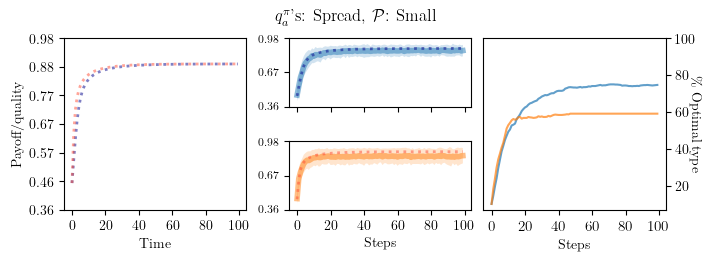

In [13]:
population_sizes = [10, 1000]
runs = 100
epochs = 100


for name in ['evenly spaced', 'near zero', 'near one']:
    for population_size in population_sizes:
        bandit = Bandit(n_action=10, mean=0, variance=1, name=name)
        mean_rewards_vr, optimal_action_vr = voter_rule(runs, population_size, epochs, bandit)
        mean_rewards_wvr, optimal_action_wvr = weighted_voter_rule(runs, population_size, epochs, bandit)
        mean_rewards_trd = taylor_replicator_dynamics(1, bandit, runs)
        mean_rewards_mrd = maynard_replicator_dynamics(1, bandit, runs)


        #plot stuff
        plt.rcParams['figure.figsize'] = [7, 2.5]
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(2, 3)
        ax0 = fig.add_subplot(gs[:, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[:, 2])
        fontsize=10
        plt.rcParams.update({'font.size': fontsize})
        ax2.sharex(ax1)
        ax3.sharex(ax1)


        # axs[2].sharex(axs[3])

        colors = ['#1f77b4', '#ff7f0e', '#ff4b33', '#00008b']
        lines_labels=[]

        max_vr = max(mean_rewards_vr.mean(axis=0) + mean_rewards_vr.std(axis=0))
        max_wvr = max(mean_rewards_wvr.mean(axis=0) + mean_rewards_wvr.std(axis=0))
        max_reward = max_vr if max_vr > max_wvr else max_wvr
        min_vr = min(mean_rewards_vr.mean(axis=0) - mean_rewards_vr.std(axis=0))
        min_wvr = min(mean_rewards_wvr.mean(axis=0) - mean_rewards_wvr.std(axis=0))
        min_reward = min_vr  if min_vr < min_wvr else min_wvr



        reward_steps = (max_reward  - min_reward)/6 + 0.1/6
        reward_ticks = [min_reward - 0.05 + i*reward_steps for i in range(7)]

        step_x = runs/5


        ax0.plot(range(runs),mean_rewards_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
        ax0.plot(range(runs),mean_rewards_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)
        ax0.set_ylim(reward_ticks[0],reward_ticks[-1])
        ax0.set_yticks(reward_ticks)
        ax0.set_yticklabels([f'{i:.2f}' for i in reward_ticks], fontsize=fontsize)
        ax0.set_xticks([i for i in np.arange(0,runs+step_x,step_x)])
        ax0.set_ylabel('Payoff/quality', fontsize=fontsize)
        
        
        ax0.set_xticklabels([f'{i:.0f}' for i in np.arange(0,runs+step_x,step_x)], fontsize=fontsize)
        ax0.set_xlabel('Time', fontsize=fontsize)
        
        # show only three points in the y axis
        small_ticks = [reward_ticks[0],reward_ticks[int(7/2)],reward_ticks[-1]]
        ax1.set_ylim(reward_ticks[0],reward_ticks[-1])
        ax2.set_ylim(reward_ticks[0],reward_ticks[-1])
        ax1.set_yticks(small_ticks)
        ax1.set_yticklabels([f'{i:.2f}' for i in small_ticks], fontsize=8)
        ax2.set_yticks(small_ticks)
        ax2.set_yticklabels([f'{i:.2f}' for i in small_ticks], fontsize=8)

        ax1.tick_params(labelbottom=False)
        ax2.set_xticks([i for i in np.arange(0,runs+step_x,step_x)])
        ax2.set_xticklabels([f'{i:.0f}' for i in np.arange(0,runs+step_x,step_x)], fontsize=fontsize)
        ax2.set_xlabel('Steps', fontsize=fontsize)


        ax1.plot(range(runs),mean_rewards_vr.mean(axis=0), label=r'$R_{\text{success}}$', color=colors[0], alpha=0.5, linewidth=4)
        ax1.plot(range(runs),mean_rewards_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
        ax1.fill_between(range(runs),mean_rewards_vr.mean(axis=0) - mean_rewards_vr.std(axis=0),mean_rewards_vr.mean(axis=0) + mean_rewards_vr.std(axis=0),facecolor=colors[0], alpha=0.2)
        ax2.plot(range(runs),mean_rewards_wvr.mean(axis=0), label=r'$R_{\text{wvoter}}$', color=colors[1], alpha=0.5, linewidth=4)
        ax2.plot(range(runs),mean_rewards_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)
        ax2.fill_between(range(runs),mean_rewards_wvr.mean(axis=0) - mean_rewards_wvr.std(axis=0),mean_rewards_wvr.mean(axis=0) + mean_rewards_wvr.std(axis=0),facecolor=colors[1], alpha=0.2)


        ax3.plot(range(runs),optimal_action_vr.mean(axis=0)*100,label=r'$R_{\text{success}}$', color=colors[0], alpha=0.7)
        ax3.plot(range(runs),optimal_action_wvr.mean(axis=0)*100,label=r'$R_{\text{wvoter}}$', color=colors[1], alpha=0.7)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_yticks([i for i in np.arange(20,120,20)])
        ax3.set_yticklabels([f'{i}' for i in np.arange(20,120,20)], fontsize=fontsize)
        ax3.set_ylabel(r'$\%$ Optimal type', fontsize=fontsize, rotation=270)
        ax3.set_xlabel('Steps', fontsize=fontsize)

        if population_size == 10:
            population_size_name = "Small"
        else: 
            population_size_name = "Large"
        
        if name == "evenly spaced":
                        title_name = 'Spread'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $\mathcal{P}$: " + str(population_size_name)

        elif name == "near zero":
                        title_name = 'Low'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $\mathcal{P}$: " + str(population_size_name)
                
        else:                
                        title_name = 'High'
                        title = r"$q^{\pi}_a$'s: "+str(title_name)+ r", $\mathcal{P}$: " + str(population_size_name)




        # set common x-axis label
        if (population_size_name == 'Large') and (title_name == 'High' or title_name == 'Spread'):
            # fig.text(0.5, -0.02, 'Runs', ha='center', va='center', fontsize=fontsize)
            fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.04), ncol=4, fontsize=fontsize)

        # set legend outside the plot
        lines_labels = [ax0.get_legend_handles_labels()]
        lines_labels.append(ax3.get_legend_handles_labels())
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


        fig.suptitle(title, fontsize=12)
        plt.savefig(f"population_experiments_scenario_{title_name}_prallel_{population_size_name}.pdf", bbox_inches='tight',dpi=900)

    


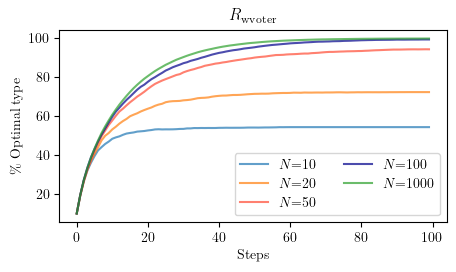

In [34]:
population_sizes = [10, 20, 50, 100, 1000]
runs = 100
epochs = 1000


fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
colors = ['#1f77b4', '#ff7f0e', '#ff4b33', '#00008b', '#2ca02c']
i = 0

for name in ['evenly spaced']:
    for population_size in population_sizes:
        bandit = Bandit(n_action=10, mean=0, variance=1, name=name)
        mean_rewards_wvr, optimal_action_wvr = weighted_voter_rule(runs, population_size, epochs, bandit)

        ax.plot(range(runs),optimal_action_wvr.mean(axis=0)*100,label=r'$N$'f'={population_size}', color=colors[i], alpha=0.7)


        i += 1

ax.set_title(r'$R_{\text{wvoter}}$', fontsize=12)
ax.set_ylabel(r'$\%$ Optimal type', fontsize=10)
ax.set_xlabel('Steps', fontsize=10)
ax.set_yticks([i for i in np.arange(20,120,20)])
ax.set_yticklabels([f'{i}' for i in np.arange(20,120,20)], fontsize=10)
ax.legend(loc='lower right', fontsize=10, ncols=2)

plt.savefig(f"population_experiments_scenario_evenly_spaced.pdf", bbox_inches='tight',dpi=900)

